In [1]:
import base64
import collections
import functools
import io
import json
import logging
import pathlib
import typing
import uuid

from PIL import Image
from PIL import ImageChops

from pikov import GuidNode, StringNode, Int64Node, JSONGraph
from pikov.pikov import SemanticGraphNode
from pikov.properties import make_guid_property, StringProperty, Int64Property

In [2]:
# Helper for displaying images.

# source: http://nbviewer.ipython.org/gist/deeplook/5162445
from io import BytesIO

from IPython import display
from PIL import Image


def display_pil_image(im):
   """Displayhook function for PIL Images, rendered as PNG."""

   b = BytesIO()
   im.save(b, format='png')
   data = b.getvalue()

   ip_img = display.Image(data=data, format='png', embed=True)
   return ip_img._repr_png_()


# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)


PIXEL_ART_CSS = (
    'image-rendering: -moz-crisp-edges; '
    'image-rendering: crisp-edges; '
    'image-rendering: pixelated; '
)


# https://stackoverflow.com/a/6204954/101923
def equal_images(im1, im2):
    return ImageChops.difference(im1, im2).getbbox() is None


In [3]:
sample_dir = (pathlib.Path("..") / ".." / "samples").resolve()

with open(sample_dir / "pikov-core.json") as fp:
    core_types = json.load(fp)
    #graph = JSONGraph.load(fp)

In [4]:
sample_path = sample_dir / "gamekitty.json"

# Merge core types into pikov.json
graph = JSONGraph.load(sample_path)
for key, item in core_types["guidMap"].items():
    graph._guid_map[key] = item

## Build names mapping

To make it a little easier to check that I'm using the correct guids, construct a mapping from names back to `guid`.

Note: this adds a constraint that no two nodes have the same name, which should not be enforced for general semantic graphs.

In [5]:
names = {}
for node in graph:
    for edge in node:
        if edge.guid == "169a81aefca74e92b45e3fa03c7021df":
            value = node[edge].value
            if value in names:
                raise ValueError('name: "{}" defined twice'.format(value))
            names[value] = node
     
names["ctor"]

GuidNode(guid="aba6ac79fd3d409da860a77c90942852")

In [6]:
def name_to_guid(name):
    if name not in names:
        return None
    node = names[name]
    if not hasattr(node, "guid"):
        return None
    return node.guid

## Pikov Classes

These classes are the core resources used in defining a "Pikov" file.

Note: ideally these classes could be derived from the graph itself, but I don't (yet) encode type or field information in the `pikov.json` semantic graph.

In [7]:
MICROS_12_FPS = int(1e6 / 12)  # 12 frames per second
MICROS_24_FPS = int(1e6 / 24)

In [8]:
class Resource(SemanticGraphNode):
    def __init__(self, graph, guid=None):
        super().__init__(names["resource"], graph, guid=guid)
        self._image = None

    relative_path = StringProperty(names["resource.relative_path"])
    
    @property
    def image(self):
        if self._image is None:
            self._image = Image.open(self._graph.filepath.parent / self.relative_path)
        return self._image


ResourceProperty = make_guid_property(Resource)

In [9]:
class Point(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["point"], guid_map, guid=guid)
    
    x = Int64Property(names["point.x"])
    y = Int64Property(names["point.y"])
    
    def __repr__(self):
        return "Point(guid='{}', x={}, y={})".format(
            self.guid,
            repr(self.x),
            repr(self.y),
        )


PointProperty = make_guid_property(Point)

In [10]:
class Vector(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["vector"], guid_map, guid=guid)
    
    x = Int64Property(names["vector.x"])
    y = Int64Property(names["vector.y"])


VectorProperty = make_guid_property(Vector)

In [11]:
class Rectangle(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["rectangle"], guid_map, guid=guid)
    
    anchor = PointProperty(names["rectangle.anchor"])
    width = Int64Property(names["rectangle.width"])
    height = Int64Property(names["rectangle.height"])
    
    def __repr__(self):
        return "Rectangle(guid='{}', anchor={}, width={}, height={})".format(
            self.guid,
            repr(self.anchor),
            repr(self.width),
            repr(self.height),
        )


RectangleProperty = make_guid_property(Rectangle)

In [12]:
class Bitmap(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["bitmap"], guid_map, guid=guid)
        self._image = None
    
    resource = ResourceProperty(names["bitmap.resource"])
    crop = RectangleProperty(names["bitmap.crop"])
        
    @property
    def image(self):
        if self._image is None:
            left = self.crop.anchor.x
            top = self.crop.anchor.y
            right = left + self.crop.width
            bottom = top + self.crop.height
            box = (left, top, right, bottom)
            self._image = self.resource.image.crop(
                box
            )
        return self._image

    def _to_data_url(self):
        image = self.image
        if not image:
            return None
        
        buffer = io.BytesIO()
        image.save(buffer, format="PNG")
        contents_base64 = base64.b64encode(buffer.getvalue()).decode("utf-8")
        return f"data:image/png;base64,{contents_base64}"
    
    
BitmapProperty = make_guid_property(Bitmap)

In [13]:
class Frame(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["frame"], guid_map, guid=guid)
    
    duration_microseconds = Int64Property(names["frame.duration_microseconds"])
    bitmap = BitmapProperty(names["frame.bitmap"])

    def _to_img(self):
        image_url = self.bitmap._to_data_url()
        if not image_url:
            return None

        return (
            f'<img alt="clip preview" '
            f'src="{image_url}" '
            f'style="width: 5em; {PIXEL_ART_CSS}">'
        )


FrameProperty = make_guid_property(Frame)

In [14]:
class FrameList(GuidNode):
    def __init__(self, graph, guid=None):
        super().__init__(graph, guid=guid)
        
        graph.set_value(
            self,
            names["ctor"],
            GuidNode(graph, guid=names["EmptyList"].guid))
        
        # Cache list so we can index by integer.
        #self._nodes = [self]

    head = FrameProperty(names["NonemptyList.head"])
    
    @property
    def tail(self):
        node = self._graph.get_value(self, names["NonemptyList.tail"])
        if node is None:
            return None
        return FrameList(self._graph, node.guid)
    
    def _set_tail(self, value):
        self._graph.set_value(
            self,
            names["NonemptyList.tail"],
            value)
    
    def append(self, value, guid=None):
        end_node = list(self._nodes())[-1]
        
        self._graph.set_value(
            end_node,
            names["ctor"],
            GuidNode(graph, guid=names["NonemptyList"].guid))
        end_node.head = value

        # New end node.
        new_end_node = FrameList(self._graph, guid=guid)
        end_node._set_tail(new_end_node)
        return new_end_node
    
    def __bool__(self):
        return self.tail is not None
    
    __nonzero__ = __bool__
    
    def __getitem__(self, key):
        if isinstance(key, int):
            frames = [frame for frame in self]
            return frames[key]
        return super().__getitem__(key)
    
    def _nodes(self):
        current_node = self
        while current_node:
            yield current_node
        yield current_node
    
    def __iter__(self):
        current_node = self
        while current_node:
            yield current_node.head
            current_node = current_node.tail

            
FrameListProperty = make_guid_property(FrameList)

In [15]:
class Transition(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["transition"], guid_map, guid=guid)
    
    source = FrameProperty(names["transition.source"])
    target = FrameProperty(names["transition.target"])

    def _to_html(self) -> str:
        source_img = self.source._to_img()
        target_img = self.target._to_img()
        return (
            '<table>'
            '<tr><th>Transition</th><th></th></tr>'
            f'<tr><td>guid</td><td>{self.guid}</td></tr>'
            f'<tr><td>name</td><td>{self.name}</td></tr>'
            f'<tr><td>source.guid</td><td>{self.source.guid}</td></tr>'
            f'<tr><td>source.image</td><td>{source_img}</td></tr>'
            f'<tr><td>target.guid</td><td>{self.target.guid}</td></tr>'
            f'<tr><td>target.image</td><td>{target_img}</td></tr>'
            '</table>'
        )

    def __repr__(self) -> str:
        return (
            'Transition('
            f'id={repr(self.guid)}, '
            f'source={repr(self.source)}, '
            f'target{repr(self.target)})'
        )

    def _repr_mimebundle_(self, include=None, exclude=None, **kwargs):
        data = {}
        should_include = functools.partial(
            _should_include, include=include, exclude=exclude)

        if should_include('text/html'):
            data['text/html'] = self._to_html()

        return data
    

TransitionProperty = make_guid_property(Transition)

In [16]:
class Sprite(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["sprite"], guid_map, guid=guid)
    
    frame = FrameProperty(names["sprite.frame"])
    position = PointProperty(names["sprite.position"])

    
SpriteProperty = make_guid_property(Sprite)

In [17]:
def _should_include(mime, include=None, exclude=None):
    if not mime:
        return False
    included = not include or mime in include
    not_excluded = not exclude or mime not in exclude
    return included and not_excluded


class Clip(SemanticGraphNode):
    def __init__(self, guid_map, guid=None):
        super().__init__(names["Clip"], guid_map, guid=guid)
    
    frames = FrameListProperty(names["Clip.frames"])
    
    def save_gif(self, fp):
        """Save this clip as a GIF to file pointer ``fp``."""
        if not self.frames:
            raise NotFound('No frames to write to GIF.')

        imgs = []
        durations = []
        previous_image = None
        for frame in self.frames:
            duration_microseconds = frame.duration_microseconds or MICROS_12_FPS
            duration = duration_microseconds / 1000  # Micros to millis

            # Increase the duration if the image is the same as the previous.
            # The GIF renderer crashes if it gets two duplicate frames.
            current_image = frame.bitmap.image
            if previous_image and equal_images(previous_image, current_image):
                durations[-1] = durations[-1] + duration
                #print("got duplicate image")
                continue
            #if previous_image == frame.image.key:
            #    durations[-1] = durations[-1] + duration
            #    continue
            #previous_image = frame.image.key

            # New image, add it to the list.
            previous_image = current_image
            imgs.append(current_image)
            durations.append(duration)
            
        #print("got {} imgs".format(len(imgs)))
        imgs[0].save(
            fp, format='gif', save_all=(len(imgs) > 1), append_images=imgs[1:],
            duration=durations if len(durations) > 1 else durations[0],
            # Always loop since this the GIF is used to preview the clip.
            loop=0)
    
    def _to_gif(self) -> typing.Optional[bytes]:
        """Write a sequence of frames to a GIF (requires Pillow).

        Returns:
            Optional[bytes]:
                Contents of a GIF rendering of the clip or ``None`` if the clip
                contains no image frames.
        """
        if not self.frames:
            return None

        output = io.BytesIO()
        self.save_gif(output)
        return output.getvalue()

    def _to_img(self):
        gif_contents = self._to_gif()
        if not gif_contents:
            return None

        contents_base64 = base64.b64encode(gif_contents).decode('utf-8')
        return (
            f'<img alt="clip preview" '
            f'src="data:image/gif;base64,{contents_base64}" '
            f'style="width: 5em; {PIXEL_ART_CSS}">'
        )

    def _to_html(self):
        #frames_repr = ', '.join((repr(frame) for frame in self.frames))
        return (
            '<table>'
            f'<tr><th>Clip</th><th></th></tr>'
            #f'<tr><td>frames</td><td>{frames_repr}</td></tr>'
            f'<tr><td>preview</td><td>{self._to_img()}</td></tr>'
            '</table>'
        )

        
    def __getitem__(self, key):
        if isinstance(key, int):
            return self.frames[key]
        return super().__getitem__(key)
    
    #def __repr__(self):
    #    return f"Clip(frames={repr(self.frames)}')"

    def _repr_mimebundle_(self, include=None, exclude=None, **kwargs):
        data = {}
        should_include = functools.partial(
            _should_include, include=include, exclude=exclude)

        # Clip can be represented by just a GIF.
        if should_include('image/gif'):
            gif_contents = self._to_gif()
            if gif_contents:
                data['image/gif'] = gif_contents

        if should_include('text/html'):
            data['text/html'] = self._to_html()

        return data

## Gamekitty

Create instances of the Pikov classes to define a concrete Pikov graph, based on my "gamekitty" animations.

In [18]:
resource = Resource(graph, guid=name_to_guid("spritesheet"))
resource.name = "spritesheet"
resource.relative_path = "./gamekitty.png"
resource

Resource(guid="710af736fb3945e28b07e0ac3a8e53d6")

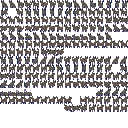

In [19]:
resource.image

### Chop image into 8x8 sprites

By creating an array of 8x8 images, we make it easier to map from PICO-8 sprite number (from my original gamekitty cart) to a Bitmap.

In [20]:
spritesheet = []
for row in range(16):
    for column in range(16):
        sprite_number = row * 16 + column
        
        crop_name = "crop[{}]".format(sprite_number)
        crop = Rectangle(graph, guid=name_to_guid(crop_name))
        crop.name = crop_name
        
        anchor_name = "anchor[{}]".format(sprite_number)
        anchor = Point(graph, guid=name_to_guid(anchor_name))
        anchor.name = anchor_name
        anchor.x = column * 8
        anchor.y = row * 8

        crop.anchor = anchor
        crop.width = 8
        crop.height = 8
        
        bitmap_name = "bitmap[{}]".format(sprite_number)
        bitmap = Bitmap(graph, guid=name_to_guid(bitmap_name))
        bitmap.name = bitmap_name
        bitmap.resource = resource
        bitmap.crop = crop
        
        spritesheet.append(bitmap)

In [21]:
list(graph.get_labels(spritesheet[4]))
spritesheet[1].image

### Create frames for each "clip"

Each animation is defined in terms of sprite numbers. Sometimes a clip should loop, but sometimes it's only used as a transition between looping clips.

In [22]:
def find_nodes(graph, ctor, cls):
    nodes = set()
    # TODO: With graph formats that have indexes, there should be a faster way.
    for node in graph:
        if node[names["ctor"]] == ctor:
            node = cls(graph, guid=node.guid)
            nodes.add(node)
    return nodes


def find_frames(graph):
    return find_nodes(graph, names["frame"], Frame)


def find_transitions(graph):
    return find_nodes(graph, names["transition"], Transition)


def find_absorbing_frames(graph):
    transitions = find_transitions(graph)
    target_frames = set()
    source_frames = set()
    for transition in transitions:
        target_frames.add(transition.target.guid)
        source_frames.add(transition.source.guid)
    return target_frames - source_frames  # In but not out. Dead end!

In [23]:
def connect_frames(graph, transition_name, source, target):
    transition = Transition(graph, guid=name_to_guid(transition_name))
    transition.name = transition_name
    transition.source = source
    transition.target = target
    return transition


def make_clip(graph, name, sprite_numbers, loop=False, duration=MICROS_12_FPS, guid=None):
    clip = Clip(graph, guid=guid)
    if clip.frames:
        logging.warning("Clip already has frames")
        return clip

    frame_list_name = "framelist[{}, 0]".format(name)
    end_of_clip = FrameList(graph, guid=name_to_guid(frame_list_name))
    clip.frames = end_of_clip
    previous_sprite_name = None
    previous_frame = None
    for sequence, sprite_number in enumerate(sprite_numbers):
        sprite_name = "{}[{}]".format(name, sequence)
        frame_name = "frames[{}]".format(sprite_name)
        frame = Frame(graph, guid=name_to_guid(frame_name))
        frame.name = frame_name
        frame.bitmap = spritesheet[sprite_number]
        frame.duration_microsections = duration
        
        if previous_sprite_name:
            transition_name = "transitions[{}, {}]".format(
                previous_sprite_name,
                sprite_name)
            connect_frames(graph, transition_name, previous_frame, frame)
        
        previous_sprite_name = sprite_name
        previous_frame = frame
        frame_list_name = "framelist[{}, {}]".format(name, sequence + 1)
        end_of_clip = end_of_clip.append(frame, guid=name_to_guid(frame_list_name))
    
    if loop:
        transition_name = "transitions[{}, {}]".format(
            previous_sprite_name,
            "{}[0]".format(name))
        connect_frames(graph, transition_name, previous_frame, clip.frames.head)
    
    return clip     

In [24]:
sit = make_clip(graph, "sit", [0], loop=True)
#sit[0].bitmap.image
sit

In [25]:
sit_to_stand = make_clip(graph, "sit_to_stand", [1,2,3,4])
sit_to_stand

In [26]:
stand_waggle = make_clip(graph, "stand_waggle", [26,4], loop=True)
stand_waggle

In [27]:
connect_frames(
    graph,
    "transitions[sit_to_stand, stand_waggle]",
    sit_to_stand[-1],
    stand_waggle[0])

Transition,
guid,406ac656142a45c0a1ff3f1716e84fac
name,"transitions[sit_to_stand, stand_waggle]"
source.guid,f6a2db33bca64aa799d3690ced24b187
source.image,
target.guid,e78112cca4b847528b93a8decd55db22
target.image,


In [28]:
stand_to_sit = make_clip(graph, "stand_to_sit", [57, 58, 59, 60, 61])
stand_to_sit

In [29]:
connect_frames(
    graph,
    "transitions[stand_waggle, stand_to_sit]",
    stand_waggle[-1],
    stand_to_sit[0])
connect_frames(
    graph,
    "transitions[stand_to_sit, sit]",
    stand_to_sit[-1],
    sit[0])

Transition,
guid,b8449c8ee4a84e5bab83d05388bb1a01
name,"transitions[stand_to_sit, sit]"
source.guid,7f00ace6eca1457f9eb90cb657708a7c
source.image,
target.guid,61bf1365bb8b40cbac34d30f7b8c1ac5
target.image,


### Create the root node

`gamekitty` should be our root node. It's the only object in our scene right now.

In [30]:
origin = Point(graph, guid=name_to_guid("origin"))
origin.name = "origin"
origin.x = 0
origin.y = 0
origin

Point(guid='01188e000bae49ec8c08891e16d25091', x=0, y=0)

In [31]:
sprite = Sprite(graph, guid=name_to_guid("gamekitty"))
graph._properties["root"] = sprite.guid
sprite.name = "gamekitty"
sprite.position = origin
sprite.frame = sit[0]
sprite

Sprite(guid="b463421ad4374bda8e088b9602fd8794")

### More clips and transitions

In [32]:
sit_paw = make_clip(graph, "sit_paw", [62, 63, 64, 65])

In [33]:
connect_frames(
    graph,
    "transitions[sit_paw, sit]",
    sit_paw[-1],
    sit[0])
connect_frames(
    graph,
    "transitions[sit, sit_paw]",
    sit[-1],
    sit_paw[0])

Transition,
guid,1b42a000d15742a1a49e2e6f3e6193be
name,"transitions[sit, sit_paw]"
source.guid,61bf1365bb8b40cbac34d30f7b8c1ac5
source.image,
target.guid,ef8dafd0bb294811b1d16653e25db192
target.image,


In [34]:
sit_to_crouch = make_clip(graph, "sit_to_crouch", [69, 70, 71])
connect_frames(
    graph,
    "transitions[sit, sit_to_crouch]",
    sit[-1],
    sit_to_crouch[0])

Transition,
guid,a4d39c1cca4742ba8d06cae39a6f1ea2
name,"transitions[sit, sit_to_crouch]"
source.guid,61bf1365bb8b40cbac34d30f7b8c1ac5
source.image,
target.guid,92772921661b432988dfaeb4b7be75ed
target.image,


In [35]:
crouch = make_clip(graph, "crouch", [72])
connect_frames(
    graph,
    "transitions[sit_to_crouch, crouch]",
    sit_to_crouch[-1],
    crouch[0])

Transition,
guid,40305fe387364850bd5aa34faf0de5f1
name,"transitions[sit_to_crouch, crouch]"
source.guid,4567bc3641bb410483b5478f32cf480a
source.image,
target.guid,f0465488f13445b991ec2bbf47f931d8
target.image,


In [36]:
crouch_to_sit = make_clip(graph, "crouch_to_sit", [75, 76, 77])
connect_frames(
    graph,
    "transitions[crouch_to_sit, sit]",
    crouch[-1],
    crouch_to_sit[0])
connect_frames(
    graph,
    "transitions[crouch_to_sit, sit]",
    crouch_to_sit[-1],
    sit[0])

Transition,
guid,41dc084c788044a083a963d649a58100
name,"transitions[crouch_to_sit, sit]"
source.guid,9fc1ab9be057424b936ecdd10949bca9
source.image,
target.guid,61bf1365bb8b40cbac34d30f7b8c1ac5
target.image,


In [37]:
find_absorbing_frames(graph)

set()

In [38]:
#frame = Frame(graph, guid="4567bc3641bb410483b5478f32cf480a")
#frame.name

In [39]:
frame = Frame(graph, guid="7f00ace6eca1457f9eb90cb657708a7c")
frame.name

'frames[stand_to_sit[4]]'

In [40]:
graph.save()